In [144]:
import json
import copy
import numpy as np
import pandas as pd
import networkx as nx
from math import sqrt
from tqdm import tqdm
from statistics import mean
from itertools import chain
from netwulf import visualize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
from joblib import Parallel, delayed
import community as community_louvain

Questions: 
Wordcloud, correct to do them for the top 10 only?
For histograms what is wanted?
How detailed should the discussions be?

To do:
Look through old feedback
Read through, and run everything
Formalia
Clean up directory

# Assignment 2

Link to github: https://github.com/NikolajT84/CSS_assignment1

### Collaboration

We have written the code and answers working together on Nikolaj's machine, which is why all commits are from the same user.

## Part 1: Properties of the real-world network of Computational Social Scientists

### Exercise: Analyzing Networks through a Random Model

#### 1. Random network

We first load the network constructed using the provided data.

In [2]:
with open('graph4.json') as f:
    g_data = json.load(f)
    
g = nx.readwrite.node_link_graph(g_data)
print(f'Number of nodes N={len(g.nodes())}')
print(f'Number of edges E={len(g.edges())}')

Number of nodes N=14196
Number of edges E=54278


So, we have a network of N=13872 nodes and E=43612 edges. We now calculate p based on the formula: $p=\frac{2E}{N(N-1)}$

In [3]:
N = 14196
E = 54278
p = 2*E/(N*(N-1))
p

0.0005387067841344808

We thereby get p = 0.00045. We now find the average degree: $\langle k\rangle =p(N-1)$

In [75]:
k_avg = p*(N-1)
k_avg

7.646942800788954

We see that the average degree should be 6.29. We now construct the random graph.

In [76]:
def randomGraph(N, p):
  G = nx.Graph()
  G.add_nodes_from(range(N))
  for i in range(N):
    for j in range(i+1, N):
      if np.random.rand() < p:
        G.add_edge(i, j)
  return G

g_random = randomGraph(N, p)
print(f'Number of nodes N={len(g_random)}')
print(f'Number of edges: E={len(g_random.edges())}')

Number of nodes N=14196
Number of edges: E=54719


As we see, the graph has approximately the expected number of edges. We visualize the graph by using the netwulf package:

In [9]:
largest_cc = max(nx.connected_components(g), key=len)
S = g.subgraph(largest_cc).copy()
visualize(S)

(None, None)

#### Random graph:
 ![Visualization of random graph](img/randomgraph.png)

#### Real graph
 ![Visualization of real graph](img/realgraph.png)

_What regime does your random network fall into? Is it above or below the critical threshold?_

Since $1<\langle k \rangle < \ln(N)$, we see that the random network is in the supercritical regime, and thereby above the critical threshhold. 

_According to the textbook, what does the network's structure resemble in this regime?_

According to the book, we now have a giant component, although isolated tree-like components still exist. The giant component will now contain loops and cycles, and a significant fraction of the total number of nodes, thereby being closer to networks we observe in the real world.

_Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations._

Qualitatively, the random network looks like an unorganized pile, whereas the real graph seems to contain clusters within the giant component. This suggests to us, that there might be a difference in the degree distributions of the two graphs. In the CSS graph there seems to be many nodes with quite small degree, and similarly quite a few nodes in the middle with high degree, which suggests a heavy-tailed distribution. If networks in the real world developed according to the Erdos-Renyi model of random graphs, this would be very unexpected. However, we know that in large real world networks the degrees are not Poisson distributed, but are much more heavy-tailed, just like we observe the CSS graph to be.


#### 2 Degree Distribution

First we plot the histogram for the random graph.

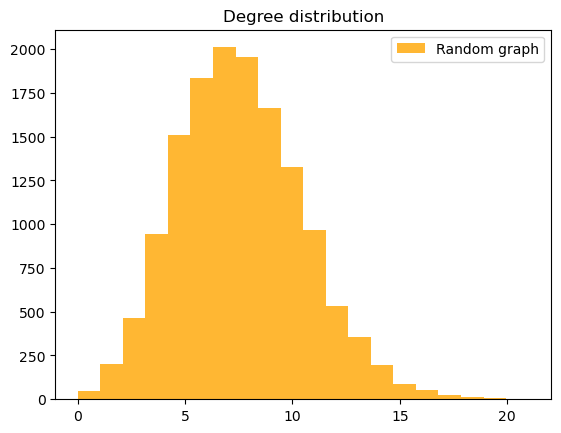

In [104]:
g_random_deg = dict(g_random.degree).values()
counts_r, bins_r, _ = plt.hist(g_random_deg, alpha=0.8, bins=20, label='Random graph', color='orange')
plt.title('Degree distribution')
plt.legend()
plt.show()

We now plot the histogram for the real graph. We here do two subplots, since the heavy-tailed distribution can be hard to visualize. We make a normal histogram cut off at degree 50 without log-scaling to show the overall shape, and then a histogram with the counts on a log scale in order to show the whole distribution. 

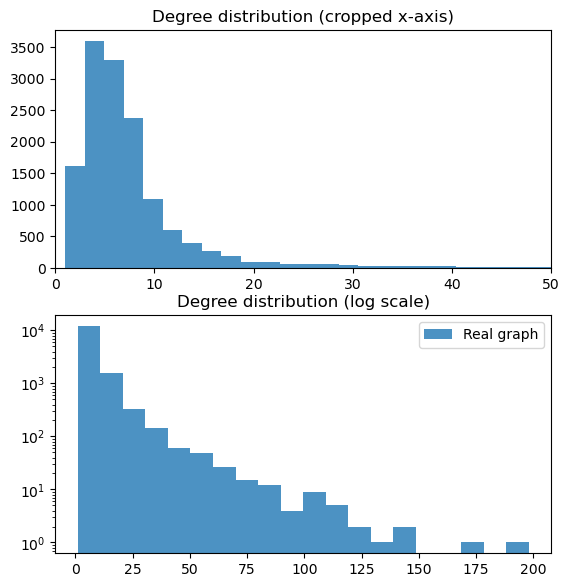

In [110]:
g_deg = dict(g.degree).values()
fig, (ax1, ax2) = plt.subplots(2,1)
counts, bins, _ = ax1.hist(g_deg, alpha=0.8, bins=100, label='Real graph')
ax1.set_title('Degree distribution (cropped x-axis)')
ax1.set_xlim(0,50)
ax2.hist(g_deg, alpha=0.8, bins=20, label='Real graph')
ax2.set_yscale('log')
ax2.set_title('Degree distribution (log scale)')
plt.subplots_adjust(top=1.2)
plt.legend()
plt.show()

We now make a plot with the distributions of the real and random network shown together, with both axis on a log scale for easier comparison. 

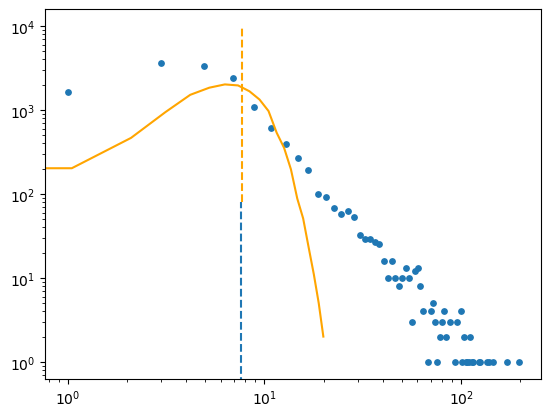

In [117]:
k = np.mean(list(g_deg))
k_r = np.mean(list(g_random_deg))
plt.scatter(bins[:-1], counts, s=15)
plt.plot(bins_r[:-1], counts_r, c='orange')
plt.vlines(k, 0, 80, linestyle='--')
plt.vlines(k_r, 80, 10000, colors='orange', linestyle='--')
plt.yscale('log')
plt.xscale('log')

_Does the average degree meaningfully represents the network's characteristics, especially in light of the insights gained from exploring heavy-tailed distributions? Discuss its adequacy or limitations in capturing the essence of the network's structural properties._

The average degree obviously tells us something about how connected the graph is, but as we see it tells us very little about the structure of the network. Although both our real and random graph have the same average degree, they differ drastically in overall structure. One might argue that a network's structural properties are very poorly explained by the average degree, since many very different degree distributions may have the same average degree.

_What differences can you observe between the real and the random distributions? How does the shape of the degree distribution for each network inform us about the network's properties?_

We see that the distribution of the real network is much more heavy-tailed in both ends, meaning that there are more sparsely connected nodes, and more very connected nodes. This means, that some nodes are extremely connected, and act as hubs between more isolated nodes. This is in contrast to the random network, were no real hubs exist, and most of the nodes have degree very quite close to the average degree. 

### Part 2: Network Analysis in Computer Science
#### Exercise 1: Mixing and Assortativity
__Part 1: Assortativity Coefficient__

We use our function from week 6:

In [4]:
def assortativity_by_att(g, att_name):
    n_edges_total = len(g.edges)
    ae_dict = defaultdict(lambda: {'a': 0,'e': 0})
    att_set = set(nx.get_node_attributes(g, att_name).values())
    for att in att_set:
        country_nodes = [node for node in g.nodes() 
                         if g.nodes[node][att_name]==att]
        g_country = g.subgraph(country_nodes)
        n_edges = len(g_country.edges)
        ae_dict[att]['e'] = n_edges/n_edges_total
        ae_dict[att]['a'] = sum([g.degree(node) for node in country_nodes])
        ae_dict[att]['a'] /= 2*n_edges_total
    
    e_sum = sum([country['e'] for country in ae_dict.values()])
    a_sum = sum([country['a']**2 for country in ae_dict.values()])
    return (e_sum - a_sum)/(1 - a_sum)

assort_g = assortativity_by_att(g, 'country')
assort_g

0.4160218823251788

Here we get an assortativity by country of 0.416.

#### Part 2: Configuration model

We now define the function for the configuration model. We add an assert statement to make sure the degree of nodes in the new graph matches the old one.

In [7]:
authors = pd.read_csv('final_authors.csv')

In [137]:
def update_neighbors(neighbors, u, v, x, y):
    neighbors[u][neighbors[u].index(v)] = y
    neighbors[v][neighbors[v].index(u)] = x
    neighbors[x][neighbors[x].index(y)] = v
    neighbors[y][neighbors[y].index(x)] = u
    return neighbors

def conf_model(g):
    n_edges_total = len(g.edges)
    g_conf = copy.deepcopy(g)
    swap_count = 0
    max_t = 1000000
    t = 0
    edge_list = list(g.edges)
    neighbors = {node: list(g.neighbors(node)) for node in list(g.nodes)}
    while swap_count < n_edges_total * 10 and t < max_t:
        if swap_count % 100000 == 0:
            print(f'{swap_count}/{n_edges_total * 10}')
        idx1, idx2 = np.random.choice(np.arange(0, n_edges_total), 2)
        edge_1, edge_2 = edge_list[idx1], edge_list[idx2]
            
        if len(set(edge_1 + edge_2)) == 4:
            if np.random.rand() > 0.5:
                edge_1 = edge_1[::-1]
                edge_list[idx1]=edge_1
            u,v = edge_1
            x,y = edge_2
            edge_1n = (u, y)
            edge_2n = (x, v)
            cond1 = u not in neighbors[y]
            cond2 = x not in neighbors[v]
            
            if cond1 and cond2:
                edge_list[idx1]=edge_1n
                edge_list[idx2]=edge_2n
                neighbors = update_neighbors(neighbors, u, v, x, y)
                swap_count += 1
        t+=1
    g_conf = nx.from_edgelist(edge_list)
    attribute_dict = {author['id']: {'display_name': author['display_name'],
                                       'country': author['country_code']}
                      for i, author in authors.iterrows()}
    nx.set_node_attributes(g_conf, attribute_dict)
    assert len(g.edges) == len(g_conf.edges), 'Number of edges not equal'
    assert sorted(dict(g.degree).items()) == sorted(dict(g_conf.degree).items()), 'Degree of nodes not the same'
    return g_conf

g_conf = conf_model(g)
assortativity_by_att(g_conf, 'country')

0/542780
100000/542780
200000/542780
300000/542780
400000/542780
500000/542780


2.18602763559737e-05

#### Part 3: Analyzing Assortativity in Random Networks

We now produce 100 random networks through the configuration model, calculate their assortativity, and plot the results alongside the value of assortativity for the real graph. Since the process is quite time-consuming, we calculate the degree assortativity in the same go.

In [44]:
def assortivity_degree(graph):
    ku = []
    kv = []
    kukv = []
    for edge in list(graph.edges):
        u, v = edge
        ku.append(graph.degree(u))
        kv.append(graph.degree(v))
        kukv.append(graph.degree(u) * graph.degree(v))
    ku_sq = [u ** 2 for u in ku]
    kv_sq = [v ** 2 for v in kv]
    r = (mean(kukv) - mean(ku) * mean(kv)) / (sqrt(mean(ku_sq) - mean(ku) ** 2) *
                                              sqrt(mean(kv_sq) - mean(kv) ** 2))
    return r

def assort_of_conf(g):
    g_conf = conf_model(g)
    return assortativity_by_att(g_conf, 'country'), assortivity_degree(g_conf)

assorts = Parallel(n_jobs=-2)(delayed(assort_of_conf)(g) for i in tqdm(range(100)))
assorts = np.array(assorts)

 77%|███████▋  | 77/100 [29:51<10:21, 27.02s/it]

KeyboardInterrupt: 

In [139]:
country_assort = assorts.T[0]
degree_assort = assorts.T[1]

[[1, 2], [3, 4]]

In [33]:
plt.hist(assorts)
plt.xlim(min(assorts) - 0.05, assort_g + 0.05)
plt.vlines(assort_g, 0, 20, color='red', linestyles='dashed')
plt.show()

{}

We see that it seems like the assortativity of the real network is definitely not by chance, thereby suggesting that authors from the same country tend to work together more often. 

#### Part 4: Assortativity by Degree

In the previous exercise we defined the function for calculating degree assortativity. We now use the results to see how significant the result for the degree assortativity is when shown against the 100 random networks. 

In [49]:
ass_deg_g = assortivity_degree(g)
ass_deg_g

0.04286376583286513

In [24]:
assorts_degree_g = assortivity_degree(g)
plt.hist(assorts_degree)
plt.xlim(min(assorts_degree) - 0.05, assorts_degree_g + 0.05)
plt.vlines(assorts_degree_g, 0, 20, color='red', linestyles='dashed')
plt.show()

2

We see that the assortativity of the real network differs quite significantly from the distribution shown by the random networks, suggesting that high degree authors tend to collaborate more with other high degree authors, than would be expected by chance.

#### Part 5: Reflection questions
_7. Assortativity by degree: Were the results of the degree assortativity in line with your expectations? Why or why not?_



_8. Edge flipping. In the process of implementing the configuration model, you were instructed to flip the edges (e.g., changing e_1 from (u,v) to (v,u)) 50% of the time. Why do you think this step is included?_

_9. Distribution of assortativity in random networks. Describe the distribution of degree assortativity values you observed for the random networks. Was the distribution pattern expected? Discuss how the nature of random network generation (specifically, the configuration model and edge flipping) might influence this distribution and whether it aligns with theoretical expectations._

### Exercise 2: Central Nodes

We use networkx's built in function to get the centrality of each node.

In [5]:
c_centrality = nx.closeness_centrality(g)
c_centrality_sorted = dict(sorted(c_centrality.items(), key=lambda item: item[1]))
top5_c = list(c_centrality_sorted.items())[:-6:-1]

In [9]:
for id, centrality in top5_c:
    name = authors.loc[authors['id'] == id, 'display_name'].iloc[0]
    print(f'Name: {name}, centrality: {centrality}')

Name: Renaud Lambiotte, centrality: 0.24477610967368213
Name: Alex Pentland, centrality: 0.24400428112300943
Name: Filippo Menczer, centrality: 0.24296517811775784
Name: Alex Pentland, centrality: 0.2410599441587279
Name: Joshua B. Tenenbaum, centrality: 0.24095641089709924


It would make sense that these individuals are leaders in their communities, and are in positions where they are often interacting with other institutes, going to conferences, and meeting people. Due to their 'networking' activities, it makes sense that they would be the ones with the most other people within short reach.  

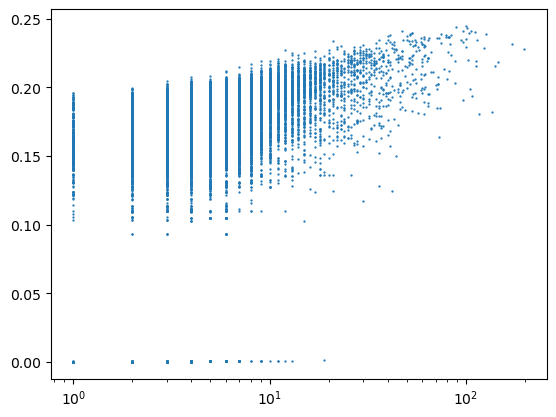

In [12]:
c_and_degree = np.array([[c, dict(g.degree)[node]] for node, c in c_centrality.items()])
plt.scatter(c_and_degree[:,1], c_and_degree[:,0], s=0.4)
plt.xscale('log')

_Plot the closeness centrality of nodes vs their degree. Is there a correlation between the two? Did you expect that? Why?_

Having plotted the degree against the closeness centrality we see that there is a positive correlation. This makes sense in that knowing more people should naturally decrease the social distance between you and most other people, so this was to be expected. 

_Repeat the two points above using eigenvector centrality instead. Do you observe any difference? Why?_

We now do the same for eigenvector centrality:

In [14]:
e_centrality = nx.eigenvector_centrality(g)
e_centrality_sorted = dict(sorted(e_centrality.items(), key=lambda item: item[1]))
top5_e = list(e_centrality_sorted.items())[:-6:-1]
for id, centrality in top5_e:
    name = authors.loc[authors['id'] == id, 'display_name'].iloc[0]
    print(f'Name: {name}, centrality: {centrality}')

Name: Alessandro Vespignani, centrality: 0.18554133645680532
Name: Nicola Perra, centrality: 0.1752875126826462
Name: Yamir Moreno, centrality: 0.16081507769449507
Name: Filippo Menczer, centrality: 0.15781985044187458
Name: Bruno Gonçalves, centrality: 0.15134260796388677


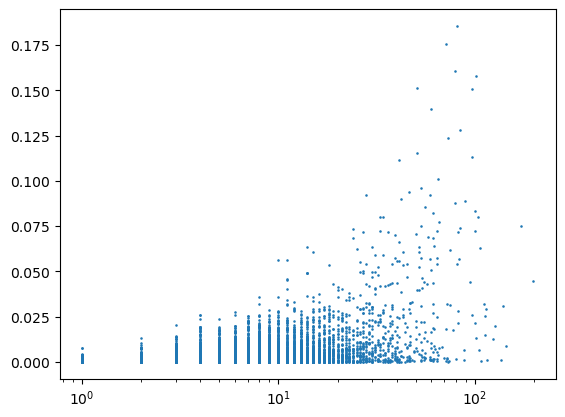

In [17]:
e_and_degree = np.array([[e, dict(g.degree)[node]] for node, e in e_centrality.items()])
plt.scatter(e_and_degree[:,1], e_and_degree[:,0], s=0.7)
plt.xscale('log')

We again see that there is a correlation between the two. The eigenvector centrality score is higher for nodes with connections to other high-scoring nodes. This means that authors who know other central authors get a higher score. It makes sense that there should be a positive relationship between degrees and eigenvector centrality, since people who know many people tend to also know more people, that also know a lot of people. Therefore it is to be expected that authors who have collaborated with many others, have also collaborated more with other central authors. 

As to the difference between the closeness centrality and eigenvector centrality, we see that relationship between degrees and eigenvector centrality is closer to linear (looks exponential when plotted on a log scale), whereas the relationship between degrees and closeness centrality seems not so linear. It should make sense that there is a more linear relationship between the eigenvector centrality and the degree, since the eigenvector centrality is higher when a nodes connections lead to other highly connected nodes, which tend to happen more often with higher degrees, whereas with closeness centrality we can have a very low centrality for a node with high degree, if that nodes connections lead to very low degree nodes.  

## Part 3: Words that characterize Computational Social Science communities
### Exercise 1 TF-IDF and the computational social science communities
_1. First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF._

_What does TF stand for?_ 

TF stands for term frequency, that is, how often a given term appears in a document.

_What does IDF stand for?_

IDF stands for inverse document frequency, that is, the inverse of the frequency with which it occurs across all documents. It is logarithmically scaled, and acts as en expression for the rarity of the term in the whole corpus.

The point of TF-IDF is to give an accurate sense of how well a given term characterizes a document. The term frequency by itself will often just yield very common words, that are rarely very descriptive of a document. By weighting the term frequency by the inverse document frequency, we amplify the words that are common in a particular document, but uncommon across the whole corpus. In this way, the terms with high scores are the ones that are common to the document in question, but not often found in the other documents, which is what we are after here.

_2. Now, we want to find out which words are important for each community, so we're going to create several large documents, one for each community. Each document includes all the tokens of abstracts written by members of a given community._

We first find the communities of the graph by the Louvain algorithm


In [20]:
partition = community_louvain.best_partition(g)
degree_dict = dict(g.degree)

We now load the data for the abstracts and the papers

In [21]:
final_abstracts = pd.read_pickle('final_abstracts_tokens.pkl')
papers = pd.read_csv('final_papers.csv')

We concatenate the author ids from the papers dataset onto the abstracts dataset

In [22]:
final_abstracts.set_index('id')
papers.set_index('id')
final_abstracts = final_abstracts.join(papers['author_ids'])

We now create a column in the abstracts dataset with the communities of all the authors of that abstract.

In [23]:
def communities_of_abstract(author_ids):
    communities = []
    for author in eval(author_ids):
        try:
            communities.append(partition[author])
        except KeyError:
            pass
    return list(set(communities))

final_abstracts['communities'] = final_abstracts['author_ids'].apply(communities_of_abstract)

We can now define the whole corpus by taking all the abstracts from each community and concatenating them.

In [25]:
corpus = final_abstracts[['communities','tokens']].explode('communities').groupby('communities')['tokens'].apply(lambda x: list(chain(*x)))

_3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the top 5 communities (by number of authors)._

We define a function to calculate the TF, along with a function to return the top k communities:


In [26]:
def top_k_terms_TF(tokens, k):
    counts = np.unique(tokens, return_counts=True)[1]
    top_k_idxs = np.argsort(counts)[:-(k+1):-1]
    return np.array(tokens)[top_k_idxs]

def top_k_communities(partition, k):
    counts = np.unique(list(partition.values()), return_counts=True)[1]
    top_k_idxs = np.argsort(counts)[:-(k+1):-1]
    return top_k_idxs

In [27]:
top_5_c = top_k_communities(partition, 5)
TF_df = pd.DataFrame(data={c: top_k_terms_TF(corpus[c], 10) for c in tqdm(top_5_c)})
TF_df

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


,8,2,26,14,12
0,trained,epidemiological,highquality,focused,prisoners_dilemma
1,like,model,represented,provide,flexibility
2,accounts,provided,handcrafted_features,happen,vibrational
3,reasoning,yearly,structural_change,appearance,cyclic
4,using,results,take,upperbody,political
5,cost,predation,evidence,modelderived,steady_state
6,systems,would,however,collaborative,transform
7,high_level,danish,low,features,lognormals
8,decisionmakers,time_periods,utterance,used,tool
9,thing,handling,innovative,order,taken_place


_Describe similarities and differences between the communities._

Based on these terms it is a bit difficult to say anything decisive about the different communities. Many of the words are general in nature, and doesn't necessarily give us any information on what the given community might revolve around. It seems like community 8 could deal with issues related to decision-making and management, whereas community 2 might deal with something concerning the natural world.

_Why aren't the TFs not necessarily a good description of the communities?_

As mentioned above, purely looking at term frequency leads us to consider terms that are just fairly common words in general. However, information theory tells us, that we should be looking for improbable words ($I=-\log p$), if we want terms containing more information. Term frequency in isolation is therefore actually a very poor way of gaining insight into a document. 

_Next, we calculate IDF for every word._


In [41]:
def IDF(corpus):
    IDF_dict = defaultdict(lambda: 0)
    N = len(corpus)
    for doc in corpus:
        for term in list(set(doc)):
            IDF_dict[term] += 1
    return {term: np.log(N/count) for term, count in IDF_dict.items()}

IDF_dict = IDF(corpus)


_What base logarithm did you use? Is that important?_

np.log uses the natural logarithm as standard, but in this case it doesn't make much of a difference, since changing the logarithm only scales the TF-IDF scores by a constant, and therefore doesn't change the rankings. 


_4. We're ready to calculate TF-IDF. Do that for the top 9 communities (by number of authors). Then for each community:_

We first define the functions for returning the IDF dictionary, and the top k terms in a document based on TF-IDF

In [39]:
def top_k_terms_TF_IDF(tokens, k, IDF_dict):
    tokens, counts = np.unique(tokens, return_counts=True)
    tfidf = np.zeros(len(counts))
    for i, (token, count) in enumerate(list(zip(tokens, counts))):
        tfidf[i] = count * IDF_dict[token]
    top_k_idxs = np.argsort(tfidf)[:-(k+1):-1]
    return tokens[top_k_idxs]

In [146]:
top_9_communities = top_k_communities(partition, 9)
TFIDF_df = pd.DataFrame(data={c: top_k_terms_TF_IDF(corpus[c], 10, IDF_dict) for c in tqdm(top_9_communities)})
TF_df = pd.DataFrame(data={c: top_k_terms_TF(corpus[c], 10) for c in tqdm(top_9_communities)})

100%|██████████| 9/9 [00:20<00:00,  2.28s/it]


_List the 10 top TF words_

In [156]:
TF_df

,8,2,26,14,12,4,65,9,13
0,trained,epidemiological,highquality,focused,prisoners_dilemma,improvement,common,humans,social
1,like,model,represented,provide,flexibility,achieves,web,framework_using,presents
2,accounts,provided,handcrafted_features,happen,vibrational,previously,critical,externos,test
3,reasoning,yearly,structural_change,appearance,cyclic,phillips,agent,rakesh,types
4,using,results,take,upperbody,political,scholars,info_claims,important,bodies
5,cost,predation,evidence,modelderived,steady_state,pabak,extended,representing,networks
6,systems,would,however,collaborative,transform,unilateral,document,objects,historical
7,high_level,danish,low,features,lognormals,bigram,three_areas,content,constraint
8,decisionmakers,time_periods,utterance,used,tool,eg,kindergartners,approach,messages
9,thing,handling,innovative,order,taken_place,eg,programs,pan,impact


_List the 10 top TF-IDF words_

In [147]:
TFIDF_df

,8,2,26,14,12,4,65,9,13
0,task,users,learning,robot,cooperation,learning,task,image,volatility
1,show,network,task,robots,network,task,text,video,market
2,users,baboons,images,users,networks,amygdala,models,images,translanguaging
3,algorithm,networks,propose,participants,dynamics,participants,users,paper,model
4,problem,social_media,method,social_media,game,stimuli,social_media,task,outsourcing
5,models,twitter,features,students,model,memory,paper,propose,price
6,model,bengalese,representation,people,players,emotion,model,users,bubbles
7,learning,song,image,design,show,processing,tasks,features,networks
8,auction,information,dataset,learning,nodes,brain,dataset,model,stocks
9,algorithms,learning,paper,task,cooperators,experiment,crosslingual,learning,network


_List the top 3 authors (by degree)_

In [109]:
author_degree_df = pd.DataFrame(data=dict(g.degree).items(), columns=['id', 'degree']).set_index('id')
partition_df = pd.DataFrame(data = partition.items(), columns=['id', 'community']).set_index('id')
authors_df = authors.set_index('id')
author_degree_df = author_degree_df.join(partition_df['community'])
author_degree_df = author_degree_df.join(authors_df['display_name'])
author_degree_df = author_degree_df.set_index('display_name')
top_3_authors = author_degree_df.groupby('community')['degree'].nlargest(3)[top_9_communities]

In [143]:
print('Top 3 authors in the top 9 communities\n', '-'*40)
for c in top_9_communities:
    print(f'Community {c}:')
    print('\n'.join(list(top_3_authors[c].index)), '\n')

Top 3 authors in the top 9 communities
 ----------------------------------------
Community 8:
Jon Kleinberg
Dan Jurafsky
Sharad Goel 

Community 2:
Filippo Menczer
Alain Barrat
Yong‐Yeol Ahn 

Community 26:
Rada Mihalcea
Cynthia Rudin
Kai He 

Community 14:
Malte Jung
Munmun De Choudhury
Koustuv Saha 

Community 12:
Yamir Moreno
José J. Ramasco
Vito Latora 

Community 4:
Jonathan D. Cohen
David A. Lagnado
Jamil Zaki 

Community 65:
Ingmar Weber
Emilio Zagheni
Arkaitz Zubiaga 

Community 9:
Alex Pentland
Bruno Lepri
Alex Pentland 

Community 13:
János Kertész
Fabrizio Lillo
Kimmo Kaski 


Above we have listed the top 3 authors from each community. Note that 'Alex Pentland' appearing twice in community 9 is not a bug, but actually two different authors, Alex Sandy Pentland and Alex Paul Pentland, who happen to be fairly prolific authors on similar topics...

_Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?_

Yes, just by looking at them, we would say that these 10 words are far more descriptive of the communities than the TF terms. Weighing the terms by the IDF takes into consideration the rarity of the words, by bringing into the equation the overall information content or 'surprisal' of a given word. Looking at the formula for the IDF, we see that it is actually exactly equal to the standard definition of information, if the probability of a term is taken to be the fraction of documents containing said term: $\log \frac{N}{n_t} = -\log \frac{n_t}{N} = - \log p_t$. 

### Exercise 2: The Wordcloud

Community 8:
Jon Kleinberg
Dan Jurafsky
Sharad Goel 


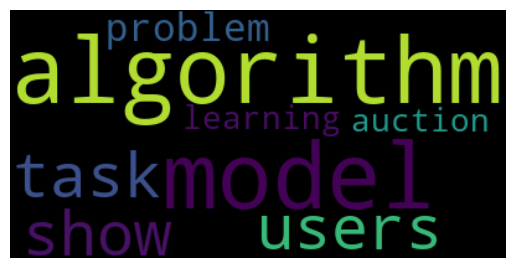

Community 2:
Filippo Menczer
Alain Barrat
Yong‐Yeol Ahn 


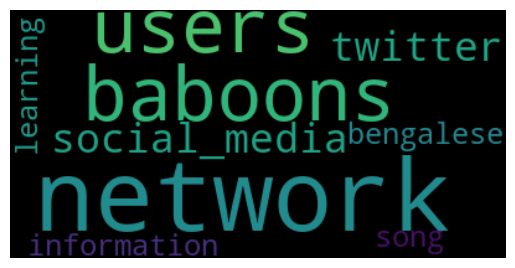

Community 26:
Rada Mihalcea
Cynthia Rudin
Kai He 


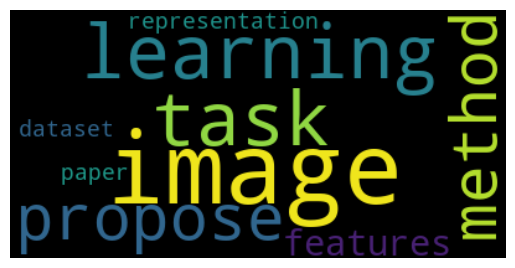

Community 14:
Malte Jung
Munmun De Choudhury
Koustuv Saha 


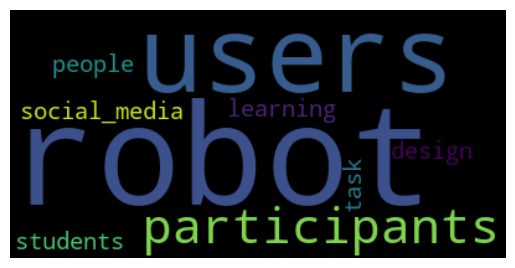

Community 12:
Yamir Moreno
José J. Ramasco
Vito Latora 


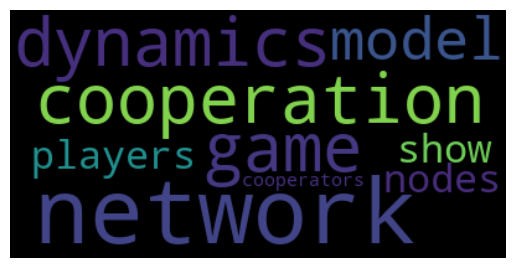

Community 4:
Jonathan D. Cohen
David A. Lagnado
Jamil Zaki 


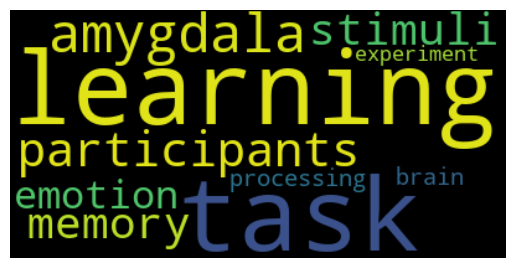

Community 65:
Ingmar Weber
Emilio Zagheni
Arkaitz Zubiaga 


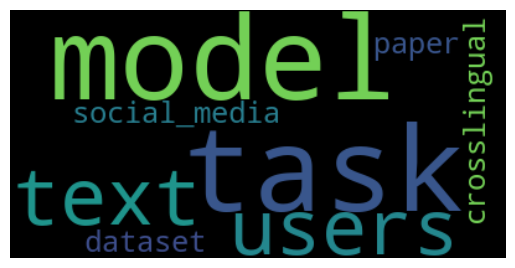

Community 9:
Alex Pentland
Bruno Lepri
Alex Pentland 


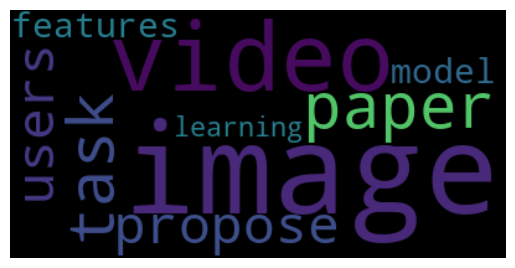

Community 13:
János Kertész
Fabrizio Lillo
Kimmo Kaski 


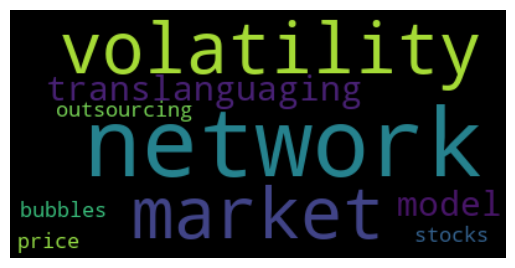

In [149]:
for c in top_9_communities:
    print(f'Community {c}:')
    print('\n'.join(list(top_3_authors[c].index)), '\n')
    text = ' '.join(TFIDF_df[c])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

_Comment on your results. What can you conclude on the different sub-communities in Computational Social Science?_

Looking at the top TF-IDF we can begin to sketch out what the different communities might revolve around:

Community 8: Machine learning theory and application.

Community 2: Social networks, and human/animal culture.

Community 26: Image recognition and machine learning.

Community 14: Robotics in application.

Community 12: Sociology.

Community 4: Neuroscience.

Community 65: Natural language processing.

Community 9: Machine learning with image/video media.

Community 13: Economics.

Community 26 and 9 seem very similar, but otherwise the top terms seem to represent fairly topically distinct communities. Maybe some information about the top authors will shed more light on these results?

_Look up online the top author in each community. In light of your search, do your results make sense?_

Community 8: Jon Kleinberg: Jon Michael Kleinberg (born 1971) is an American computer scientist and the Tisch University Professor of Computer Science and Information Science at Cornell University known for his work in algorithms and networks.

Community 2: Filippo Menczer: Menczer's research focuses on Web science, social networks, social media, social computation, Web mining, data science, distributed and intelligent Web applications, and modeling of complex information networks. \[...] Menczer is also known for his work on social phishing

Community 26: Rada Mihalcea: She made influential contribution to natural language processing, multimodal processing, and computational social science.

Community 14: Malte Jung: Malte Jung is a research scientist who studies human-robot interaction in groups and teams.

Community 12: Yamir Moreno: Yamir Moreno (1970; Havana) is a professor of Physics at the Department of Theoretical Physics of the University of Zaragoza and Director of the Institute for Biocomputation and Physics of Complex Systems at the same institution.

Community 4: Jonathan D. Cohen: Jonathan David Cohen is an American psychologist and cognitive neuroscientist.

Community 65: Ingmar Weber: Ingmar Weber is a German computer scientist known for his research on Computational Social Science in which he uses online data to study population behavior.

Community 9: Alex Pentland: Alex Paul "Sandy" Pentland (born 1951) is an American computer scientist, the Toshiba Professor of Media Arts and Sciences at MIT, and serial entrepreneur.

Community 13: János Kertész: János Kertész is a Hungarian physicist known for his contributions to the fields of econophysics, complex networks, and the application of fractal geometry in physical problems.

Overall our results seem to make sense, as it seems like for most of the communities, the top author seems to be mainly involved in the kinds of topics suggested by the top terms as defined by TF-IDF. 


### Exercise 3: Computational Social Science

_Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science._

Given that the surveys are not accesible anymore, it is a bit hard to go back and revise the answers given there. However, after our analysis, we think it could be interesting to work with Wikipedia, since it seems to be amenable to many of the key analytic methods we have used thus far, especially network analysis and NLP, given that it is a communal effort that as mainly text-based.

_In light of your data-driven analysis, has your understanding of the field changed? How?_

We were surprised by how broad the different research topics in CSS span. The work we have done thus far have also expanded our ideas about how effective the tools employed in CSS - webscraping, network analysis, NLP - can be in tackling many different questions, especially with how much information is available on the internet, if one knows how to get it. 

